## 25.0 Refining Chinese rule-based ABSA

- Author: Nana (Ching Wen Yang)
- Created at: 2022.08.01

**Goals**
- Refine by dependency by POS tags
**Reference**
- CKIP part of speech tagging scheme: https://ckip.iis.sinica.edu.tw/CKIP/paper/Sinica%20Corpus%20user%20manual.pdf
    - Na: Common Noun
    - Nb: Proper Noun
    - Nc: Place Noun
    - Nd: Time Noun


In [1]:
import sys, os
import pandas as pd

### parsing sents to dep trees

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
!gpustat

sky                            Wed Aug 24 15:32:02 2022  470.141.03
[0] NVIDIA GeForce GTX 1080 Ti | 25'C,   0 % |  5938 / 11178 MB | cindy(1067M) cindy(1111M) chyiin(1947M) nana2929(1811M)
[1] NVIDIA GeForce GTX 1080 Ti | 28'C,   0 % |  8915 / 11178 MB | chyiin(8913M)
[2] NVIDIA GeForce GTX 1080 Ti | 27'C,   0 % |  3103 / 11178 MB | nana2929(3101M)
[3] NVIDIA GeForce GTX 1080 Ti | 24'C,   0 % |     2 / 11178 MB |


In [3]:
'''path of source codes'''

root_path = '/share/home/nana2929/'
DepTree_path = '/share/home/nana2929/repo/src/'
for x in [root_path, DepTree_path]:
    if x not in sys.path:
        sys.path.append(x)

import chyiin_ch_parser
from chyiin_ch_parser import dependency_parser
from DepTree import DepTree
ch_parser = dependency_parser.chinese_parser(port=2022, device_id=2) # the port that server_process runs on 


'推薦苦瓜，但可以不要一直催人結帳嗎。', 
              '水餃和湯都不錯，但小菜不太好吃', '雞肉和大滷麵都不喜歡', '一顆的份量就好大一個，還吃的到干貝一絲一絲的',
              '食物部分很讚！也很平價，薯餅塔很推薦，裡面還有牽長長的乳酪絲，泡菜燒肉蛋餅很入味',
             '湯喝起來濃郁卻不膩，可以一口接一口喝。',
             '整體吃下來口味偏鹹完全不需要加任何醬料，必須配很多飯才會爽。', 
              '宮保蝦球很辣，麻香。其他都好吃。',
             '推薦的：鹹蛋苦瓜、煎豬肝、炒菜類、老皮嫩豆腐、松阪豬肉、金沙南瓜、炒海瓜子等',
              '三杯中卷裡面的中卷很少，大多是薑片跟洋蔥，不過這個價格也是可以了。',
              '口味稍偏重，每道菜的配料都很足，但超適合配飯，佐料自取吃到飽很貼心，有機會會再訪',
              '出餐快、口味濃、氣氛佳，適合大吃大喝、放心喧嘩的好地方↖(^ω^)↗',
             '最愛老皮嫩肉跟炒羊肉平價又好吃'

In [15]:
test_sents = [#'蛋黃酥和蘿蔔糕很好吃，清蒸鱸魚不太新鮮。老闆娘人很好。', 
              '清蒸鱸魚,不太新鮮?有點糟。老闆娘人很好。']  #comma-separated
              #'清蒸鱸魚，不太新鮮。有點糟。老闆娘人很好。']  # peiod-separated

In [19]:
store = {}
for test_sent in test_sents:
    ws, pos, deptree = ch_parser.output(test_sent)  
    store[test_sent] = (ws, pos, deptree)

### 0628爬的松園牛肉麵評論

In [7]:
filepath = f'../data/0628-beef-noodles/review_clean_parsed.pkl'
df = pd.read_pickle(filepath)

In [8]:
# s, (ws, pos, tree) = list(store.items())[8] # 不太好：5, # '其他 Neqa'不在我定義的Nouns裡
# r = {'sentence': s,
#     'word_seg': ws,
#     'pos': pos, 
#     'dependency_parse': tree}
filepath = f'../data/0628-beef-noodles/review_clean_parsed.pkl'
import random 
rindex = random.randint(0, len(df)-1)
print(rindex)
df = pd.read_pickle(filepath) # 不是neg抓不出來...(parser給標籤的問題）
row = df.iloc[rindex]
print(row['pos'])
print(row['dependency_parse'])
tree = DepTree(row, outdir = './')
tree.predict()

30
[(0, 'root root'), (1, '這 Nep'), (2, '絕對 D'), (3, '是 SHI'), (4, '我 Nh'), (5, '這 Nep'), (6, '輩子 Na'), (7, '吃 VC'), (8, '過 Di'), (9, '最 Dfa'), (10, '難吃 VH'), (11, '的 DE'), (12, '牛肉 Na'), (13, '麵 Na')]
[('3 - 是 SHI', '1 - 這 Nep', 'nsubj'), ('3 - 是 SHI', '2 - 絕對 D', 'advmod'), ('0 - root root', '3 - 是 SHI', 'root'), ('7 - 吃 VC', '4 - 我 Nh', 'nsubj'), ('6 - 輩子 Na', '5 - 這 Nep', 'det'), ('7 - 吃 VC', '6 - 輩子 Na', 'dep'), ('13 - 麵 Na', '7 - 吃 VC', 'rcmod'), ('7 - 吃 VC', '8 - 過 Di', 'asp'), ('10 - 難吃 VH', '9 - 最 Dfa', 'advmod'), ('13 - 麵 Na', '10 - 難吃 VH', 'advmod'), ('10 - 難吃 VH', '11 - 的 DE', 'cpm'), ('3 - 是 SHI', '12 - 牛肉 Na', 'attr'), ('3 - 是 SHI', '13 - 麵 Na', 'attr')]


TypeError: __init__() missing 1 required positional argument: 'logfile'

### 0705 測試 negation, conjunction 用的自製評論

In [ ]:
import random
filepath = f'../data/0705-special-cases/0705-dep-testdata_parsed.pkl' 
df = pd.read_pickle(filepath)
rindex = random.randint(0, len(df)-1)
print(rindex)
row = df.iloc[rindex]
print(row['pos'])
print(row['dependency_parse'])
tree = DepTree(row, outdir = './')
tree.predict()

In [ ]:
tree.to_image()

### 0801自己找的一些評論 
老師的例子、Google上抓一些


In [20]:
test_sents

['清蒸鱸魚,不太新鮮?有點糟。老闆娘人很好。']

In [21]:
import random
rindex_ = 0 # random.randint(0, len(test_sents)-1) 
print(f'rindex_ {rindex_}')
s, (ws, pos, tree) = list(store.items())[rindex_] 
print(pos)
print(tree)
# good: 0 (老師給的例子), 1, 2, 5 (rule 1)
# not so good: 4 ('其他 Neqa'不在我定義的Nouns裡), 
# not so good: 12 用文字距離去停止opinion-aspect太長距離的連結
print(s)
r = {'sentence': s,
    'word_seg': ws,
    'pos': pos, 
    'dependency_parse': tree}
tree = DepTree(r, logfile = './25.5-test-dep/test.log', outdir = './25.5-test-dep')
print(tree.predict())
print(tree.periods)
tree.clean_logging()
# removing all handlers

DepTree|======= Dep Tree =======
DepTree|finished loading aspect lexicon.
DepTree|finished loading opinion lexicon.


rindex_ 0
[(0, 'root root'), (1, '清蒸鱸魚 Na'), (2, ', COMMACATEGORY'), (3, '不 D'), (4, '太 Dfa'), (5, '新鮮 VH'), (6, '? QUESTIONCATEGORY'), (7, '有點 Dfa'), (8, '糟 VH'), (9, '。 PERIODCATEGORY'), (10, '老闆娘人 Na'), (11, '很 Dfa'), (12, '好 VH'), (13, '。 PERIODCATEGORY')]
[('5 - 新鮮 VH', '1 - 清蒸鱸魚 Na', 'amod'), ('5 - 新鮮 VH', '2 - , COMMACATEGORY', 'punct'), ('5 - 新鮮 VH', '3 - 不 D', 'neg'), ('5 - 新鮮 VH', '4 - 太 Dfa', 'advmod'), ('0 - root root', '5 - 新鮮 VH', 'root'), ('5 - 新鮮 VH', '6 - ? QUESTIONCATEGORY', 'punct'), ('8 - 糟 VH', '7 - 有點 Dfa', 'advmod'), ('5 - 新鮮 VH', '8 - 糟 VH', 'dep'), ('5 - 新鮮 VH', '9 - 。 PERIODCATEGORY', 'punct'), ('12 - 好 VH', '10 - 老闆娘人 Na', 'nn'), ('12 - 好 VH', '11 - 很 Dfa', 'advmod'), ('5 - 新鮮 VH', '12 - 好 VH', 'conj'), ('5 - 新鮮 VH', '13 - 。 PERIODCATEGORY', 'punct')]
清蒸鱸魚,不太新鮮?有點糟。老闆娘人很好。


DepTree|[lexicon-based] detected aspects: [{'id': 1, 'token': '清蒸鱸魚'}]
DepTree|[lexicon-based] detected opinions: [{'id': 5, 'token': '新鮮', 'polarity': 'positive'}, {'id': 8, 'token': '糟', 'polarity': 'negative'}, {'id': 12, 'token': '好', 'polarity': 'positive'}]
DepTree|[Rule 1] Detect NOUN neighbor in subtree;                             new aspect 清蒸鱸魚 is added.
DepTree|[Rule 1] Detect NOUN neighbor in subtree;                             new aspect 老闆娘人 is added.
DepTree|[Rule 5] Detected crossing boundary pair 清蒸鱸魚 and 好, ignore the pair.
DepTree|[Rule 5] Detected crossing boundary pair 清蒸鱸魚 and 好, ignore the pair.
DepTree|[Rule 3] Detect negation on 新鮮; polarity is reversed.


!neg_detect opn: [5]
!neg_detect opn: [8]
!neg_detect opn: [12]
(defaultdict(<class 'list'>, {'清蒸鱸魚': [('不新鮮', 'negative'), ('糟', 'negative')], '老闆娘人': [('好', 'positive')]}), '[清蒸鱸魚],<不>太<新鮮>?有點<糟>。[老闆娘人]很<好>。')
[9, 13]
0 remaining handlers.


In [19]:
tree.clean_logging()

0 remaining handlers.


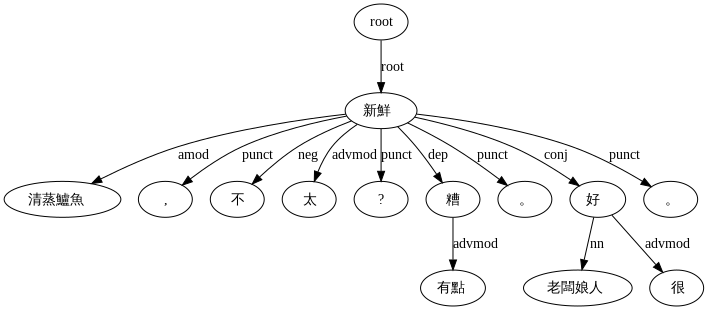

In [22]:
tree.to_image()

### output

In [ ]:
# 做成dictionary

### test subtree algorithms

In [ ]:
from networkx.algorithms.traversal.depth_first_search import dfs_tree
print(tree.nodes)
subtree_at3 = dfs_tree(tree.dG, 3) # 好吃
subtree_at7 = dfs_tree(tree.dG, 7) # 好

In [ ]:
# test subtree 
subtree_at3.nodes

In [ ]:
subtree_at7.nodes